In [1]:
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
import statistics
from statistics import mode

import librosa
import librosa.display

# to play the audio files
from IPython.display import Audio

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

import keras
from sklearn.preprocessing import StandardScaler

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
# path = "D:/SEM 3/Project/Test/03-01-01-01-01-01-01.wav"
# path = "D:/SEM 3/Project/Test/OAF_back_happy.wav"
path = "D:/speech-emotion-recognition - Capstone/Dataset/Tess/OAF_happy/OAF_back_happy.wav"
# path = "D:/SEM 3/Project/Test/03-01-02-02-02-02-20.wav"

data, sampling_rate = librosa.load(path)

In [4]:
def create_waveplot(data, sr):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot', size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram', size=20)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

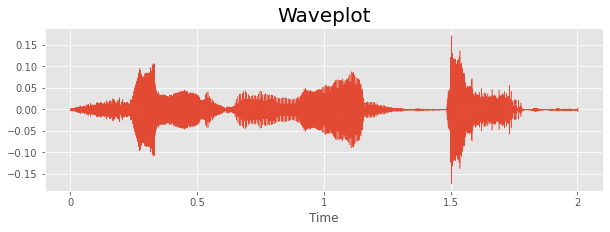

In [5]:
create_waveplot(data, sampling_rate)

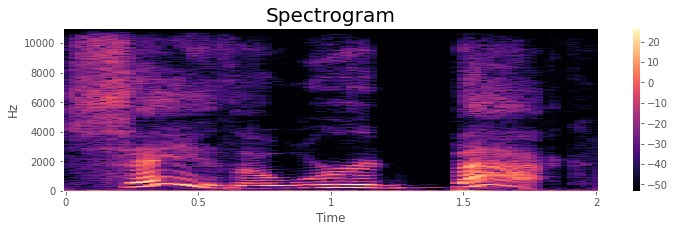

In [6]:
create_spectrogram(data, sampling_rate)

In [7]:
Audio(path)

In [8]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [9]:
# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [10]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)))
    return result

In [11]:
duration = 2.5
offset = 0.6

data, sample_rate = librosa.load(path, duration=duration, offset=offset)

# without augmentation
res1 = extract_features(data, sample_rate)
result = np.array(res1)

# data with noise
noise_data = noise(data, random=True)
res2 = extract_features(noise_data, sample_rate)
result = np.vstack((result, res2)) # stacking vertically

 # data with pitching
pitched_data = pitch(data, sample_rate, random=True)
res3 = extract_features(pitched_data, sample_rate)
result = np.vstack((result, res3)) # stacking vertically

# data with pitching and white_noise
new_data = pitch(data, sample_rate, random=True)
data_noise_pitch = noise(new_data, random=True)
res3 = extract_features(data_noise_pitch, sample_rate)
result = np.vstack((result, res3)) # stacking vertically

In [12]:
X = []

for ele in result:
    X.append(ele)
    
features_test_df = pd.DataFrame(X)

In [13]:
if features_test_df.shape[1] < 2376:
    cols = list(range(features_test_df.shape[1], 2376))
    df_test = pd.DataFrame(np.nan, index=[0, 1, 2, 3], columns=cols)
    features_test_df = pd.concat([features_test_df, df_test], axis=1, join='inner')
    
# Check for missing values
# features_test_df.isnull().sum()

# Fill NaN with 0
features_test_df = features_test_df.fillna(0)

In [14]:
X_train_org = pd.read_csv('X_train.csv')

In [15]:
# Standardize data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_org)
X = scaler.transform(features_test_df)

# We have to use 1-dimensional CNN which need specifical shape:
X = np.expand_dims(X, axis=2)

In [16]:
train_model = keras.models.load_model('speech_model.h5', custom_objects={'f1_m' : f1_m})

In [17]:
y_pred = train_model.predict(X)
y_pred = np.argmax(y_pred, axis=1)
y_pred = y_pred.tolist()

y_pred = statistics.mode(y_pred)

y_pred_dict = {0 : 'angry', 1 : 'calm', 2 : 'disgust', 3 : 'fear', 4 : 'happy', 5 : 'neutral', 6 : 'sad', 7 : 'surprise'}

predicted_emotion = y_pred_dict[y_pred]
predicted_emotion

'happy'